Firstly, the neccesary dependencies are imported:

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pandas as pd
import urllib.request
import gzip
import os
from PIL import Image
from matplotlib.patches import Rectangle

For map data the Shuttle Radar Topography Mission 30-Meter SRTM Elevation Data is used. The data can be downloaded in a resolution of 1° x 1°.

In [41]:
def download_elevation(map_boundaries):
    lat_min = np.minimum(map_boundaries[0], map_boundaries[1])
    lat_max = np.maximum(map_boundaries[0], map_boundaries[1])
    long_min = np.minimum(map_boundaries[2], map_boundaries[3])
    long_max = np.maximum(map_boundaries[2], map_boundaries[3])

    lat_range = np.arange(np.floor(lat_min), np.ceil(lat_max), 1)
    long_range = np.arange(np.floor(long_min), np.ceil(long_max), 1)

    merged_map = np.zeros([len(lat_range)*3601, len(long_range)*3601])

    for i, latitude in enumerate(lat_range):
        for j, longitude in enumerate(long_range):
            if latitude < 0:
                lat_str = "S"+str(int(np.floor(-latitude))).zfill(2)
            else:
                lat_str = "N"+str(int(np.floor(latitude))).zfill(2)
                
            if longitude < 0:
                long_str = "W"+str(int(np.floor(-longitude))).zfill(3)
            else:
                long_str = "E"+str(int(np.floor(longitude))).zfill(3)

            output_name = f"{lat_str}{long_str}"
            hgt_gz_file = "../temp/"+output_name+".hgt.gz"
            hgt_file = '../temp/'+ output_name+ '.hgt'
            # tif_file = '../temp/'+ output_name+ '.tif'

            if os.path.exists(hgt_file):
                # print("File exists!")
                pass
            else:
                print("File does not exist.")

                url = f"https://s3.amazonaws.com/elevation-tiles-prod/skadi/{lat_str}/{output_name}"+".hgt.gz"
                
                urllib.request.urlretrieve(url, hgt_gz_file)

                with gzip.open(hgt_gz_file, 'rb') as f_in:
                    with open(hgt_file, 'wb') as f_out:
                        f_out.write(f_in.read())
                os.remove(hgt_gz_file)
            
            with open(hgt_file, 'rb') as f:
                data = np.frombuffer(f.read(), np.dtype('>i2')).reshape((3601, 3601))
                data = np.flip(data, axis=0)

            image = Image.fromarray(data)

            merged_map[i*3601:(i+1)*3601, j*3601:(j+1)*3601] = data

    srtm_latitude = np.linspace(np.floor(lat_min), np.ceil(lat_max), merged_map.shape[0])
    srtm_longitude = np.linspace(np.floor(long_min), np.ceil(long_max), merged_map.shape[1])

    return srtm_longitude, srtm_latitude, merged_map

Now let's test the function.

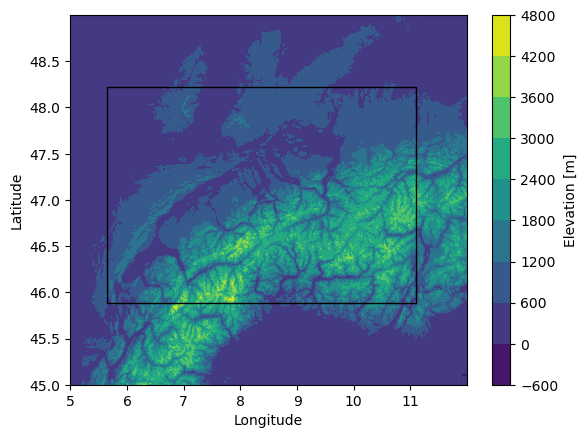

In [42]:
map_boundaries = np.array([45.88, 48.22, 5.64, 11.09])

srtm_longitude, srtm_latitude, merged_map = download_elevation(map_boundaries)

plt.figure()
plt.contourf(srtm_longitude[::10],srtm_latitude[::10],  merged_map[::10, ::10])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
currentAxis = plt.gca()
currentAxis.add_patch(
    Rectangle(
        xy=(map_boundaries[2], map_boundaries[0]),  # point of origin.
        width=(map_boundaries[3]-map_boundaries[2]), height=(map_boundaries[1]-map_boundaries[0]), linewidth=1,
        color='k', fill=False))
plt.colorbar(label="Elevation [m]")

Now limit the of the image (Indicated by the black border)

In [43]:
def generate_subarray(original_array, row_points, col_points, subarray_bounds):
    start_row = np.argmin(np.abs(row_points - subarray_bounds[0]))
    end_row = np.argmin(np.abs(row_points - subarray_bounds[1])) 
    start_col = np.argmin(np.abs(col_points - subarray_bounds[2]))
    end_col = np.argmin(np.abs(col_points - subarray_bounds[3])) 
    
    subarray = original_array[start_row:end_row+1, start_col:end_col+1]
    subarray_bounds = [row_points[start_row], row_points[end_row], col_points[start_col], col_points[end_col]]
    subrow_points = row_points[start_row:end_row+1]
    subcol_points = col_points[start_col:end_col+1]
    
    return subarray, subrow_points, subcol_points, subarray_bounds

Again, let's test the function.

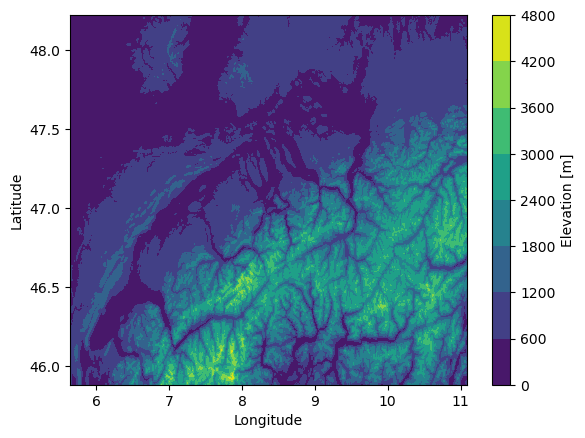

In [44]:
subarray, subrow_points, subcol_points, subarray_bounds = generate_subarray(merged_map, srtm_latitude, srtm_longitude, map_boundaries)

plt.figure()
plt.contourf(subcol_points[::10], subrow_points[::10], subarray[::10, ::10])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Elevation [m]")